<b>Group:

Dimitris Voukatas: s230148

Elli Georgiou: s223408

Maria Katarachia: s213633

Michail-Achillefs Katarachias: s222653

Stavroula Douva: s222652

##  Import libraries ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Open the file

In [2]:
file_path = 'Trips_2018.csv'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(file_path, 'r') as f:
    df = pd.read_csv(f)

# Take a sample of the data. Remove this cell in the last version of the project.

In [3]:
df = df.sample(n=10000, random_state=42)

## Get the keys

In [4]:
df = df.drop(df.columns[0], axis=1) # We are dropping the first coolumn because it is just an index
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 16303534 to 4635301
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             10000 non-null  int64  
 1   starttime                10000 non-null  object 
 2   stoptime                 10000 non-null  object 
 3   start_station_id         9999 non-null   float64
 4   start_station_latitude   10000 non-null  float64
 5   start_station_longitude  10000 non-null  float64
 6   end_station_id           9999 non-null   float64
 7   end_station_latitude     10000 non-null  float64
 8   end_station_longitude    10000 non-null  float64
 9   bikeid                   10000 non-null  int64  
 10  usertype                 10000 non-null  object 
 11  birth_year               10000 non-null  int64  
 12  gender                   10000 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.1+ MB


## See how many the missing values are (they are 0.01% of the dataset, we can drop them)

In [5]:
# # Missing values
# missing_values = df.isnull().sum()
# print(missing_values)

# # Drop rows with the missing IDs
# df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
# df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]
# df

# df['birth_year'].hist(bins=50, figsize=(20, 15))
# find the range of the 99% of the birth year

## Make a historgram of the birth years to see the distribution and keep the 99th percentile of the data

1950.0


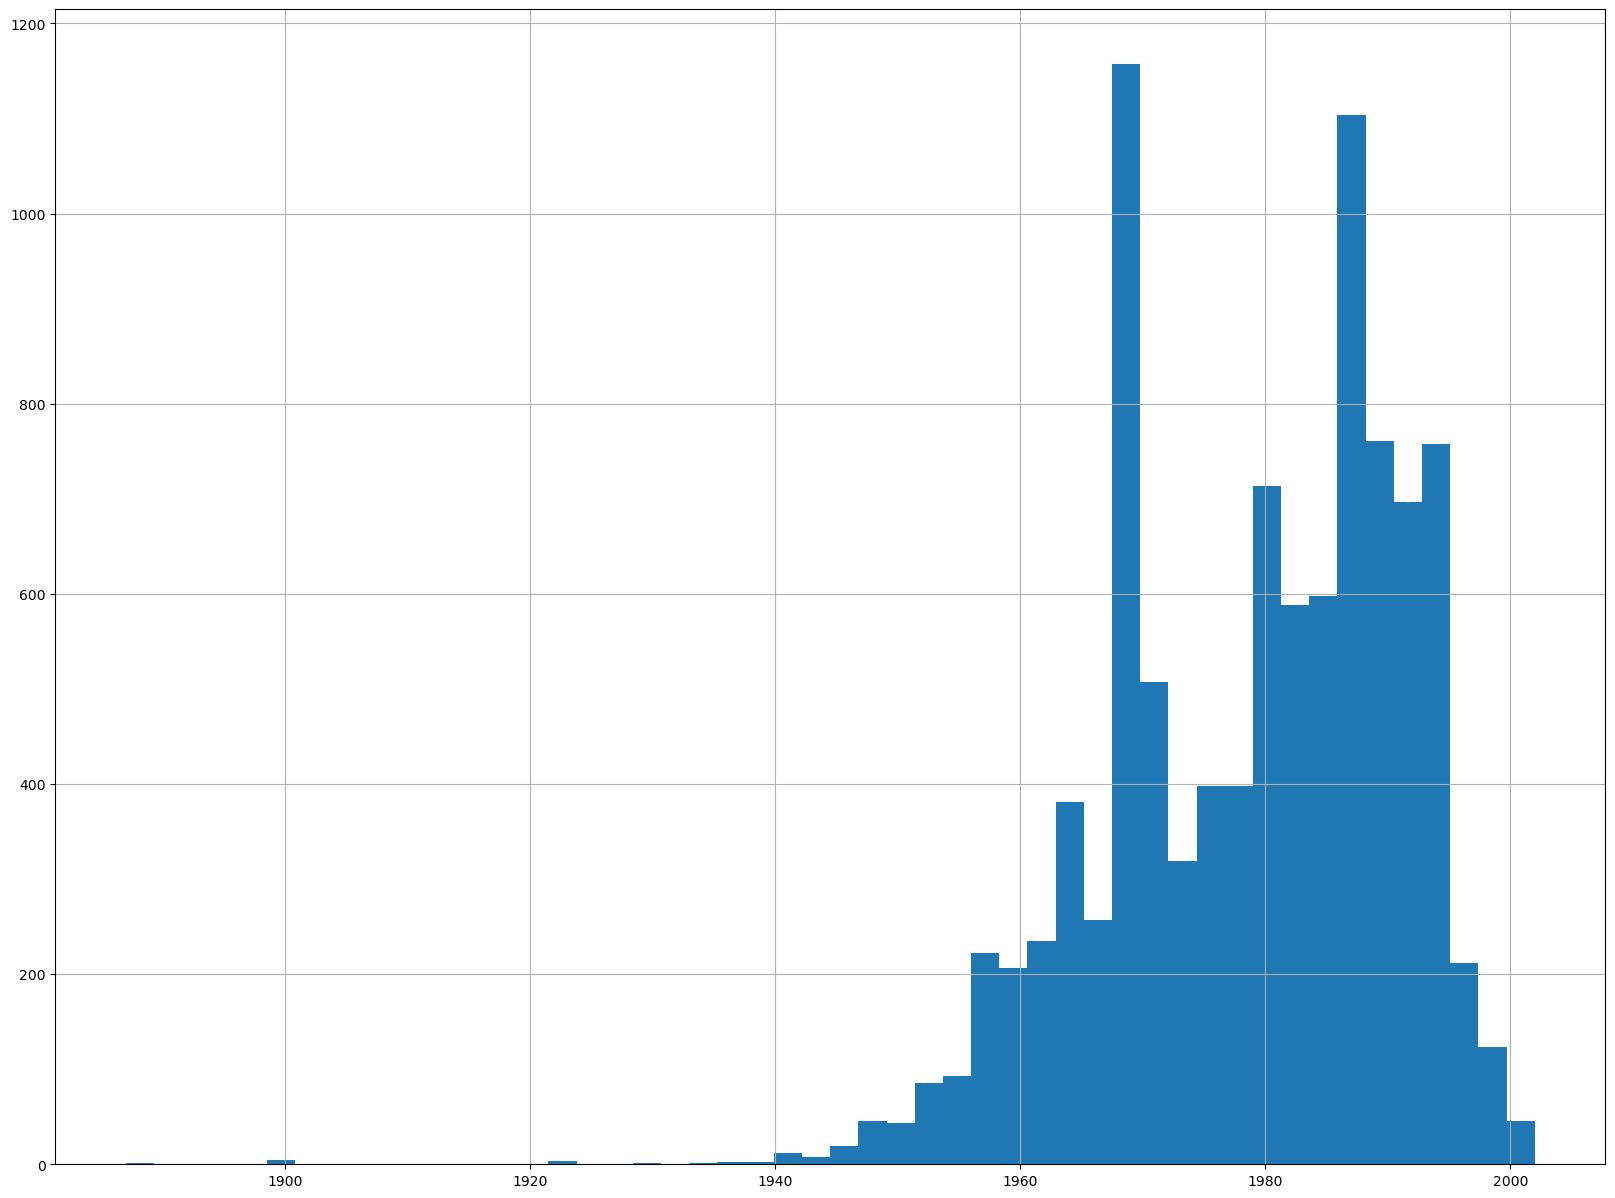

In [6]:

df.birth_year.hist(bins=50, figsize=(20, 15))
print(df['birth_year'].quantile(0.01))

## Drop the rows where birth_year was out of the 99th percentile

<class 'pandas.core.frame.DataFrame'>
Index: 9883 entries, 16303534 to 4635301
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             9883 non-null   int64  
 1   starttime                9883 non-null   object 
 2   stoptime                 9883 non-null   object 
 3   start_station_id         9882 non-null   float64
 4   start_station_latitude   9883 non-null   float64
 5   start_station_longitude  9883 non-null   float64
 6   end_station_id           9882 non-null   float64
 7   end_station_latitude     9883 non-null   float64
 8   end_station_longitude    9883 non-null   float64
 9   bikeid                   9883 non-null   int64  
 10  usertype                 9883 non-null   object 
 11  birth_year               9883 non-null   int64  
 12  gender                   9883 non-null   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.1+ MB


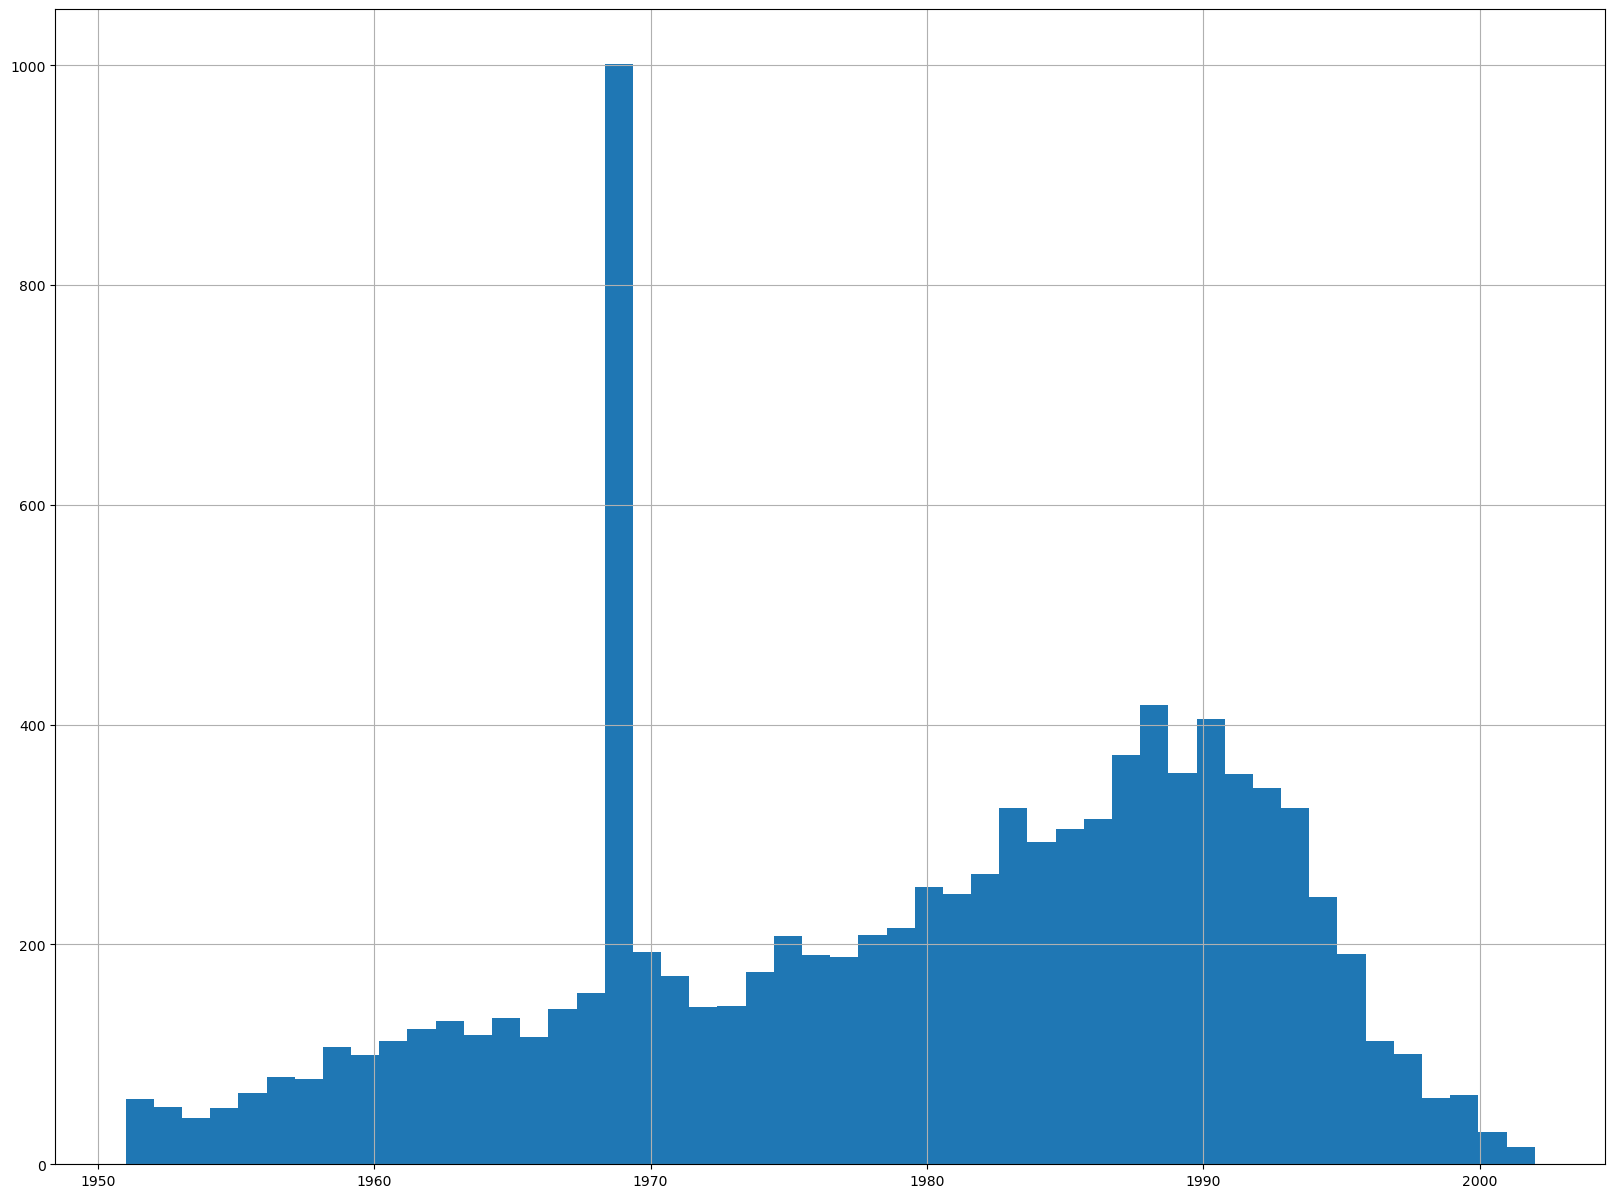

In [7]:
df = df[df['birth_year'] > df['birth_year'].quantile(0.01)]
df.birth_year.hist(bins=50, figsize=(20, 15))
df.info()

# PCA to find the most important features

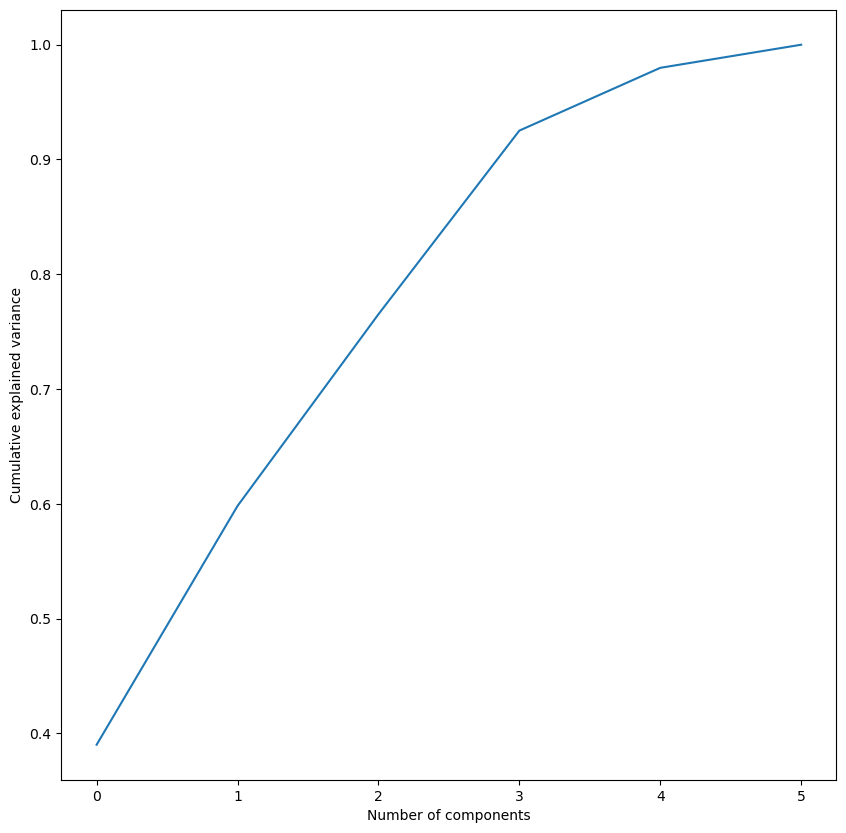


Principal Component 1 Loadings:
end_station_latitude       0.532709
start_station_latitude     0.527377
end_station_longitude      0.470786
start_station_longitude    0.464599
tripduration               0.024402
birth_year                 0.002574
Name: 0, dtype: float64

Principal Component 2 Loadings:
start_station_longitude    0.498649
end_station_longitude      0.489408
birth_year                 0.360527
tripduration               0.005509
end_station_latitude      -0.432637
start_station_latitude    -0.441185
Name: 1, dtype: float64

Principal Component 3 Loadings:
tripduration               0.965395
start_station_longitude    0.044311
end_station_longitude      0.028154
start_station_latitude    -0.048939
end_station_latitude      -0.058122
birth_year                -0.243894
Name: 2, dtype: float64

Principal Component 4 Loadings:
birth_year                 0.900274
tripduration               0.259239
start_station_latitude     0.166112
end_station_latitude       0.151725
end_

In [8]:
# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration']])
scaled_df = pd.DataFrame(scaled_df, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])

# PCA using all the features
pca = PCA(n_components=6)
pca.fit(scaled_df)
pca_df = pca.transform(scaled_df)
pca_df = pd.DataFrame(pca.components_, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])


plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig('plots/pca.png')
plt.show()

corr_matrix = scaled_df.corr()
corr_matrix['tripduration'].sort_values(ascending=False)

# Print the loadings for each principal component
for i in range(len(pca_df)):
    print(f"\nPrincipal Component {i + 1} Loadings:")
    print(pca_df.iloc[i].sort_values(ascending=False))


/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

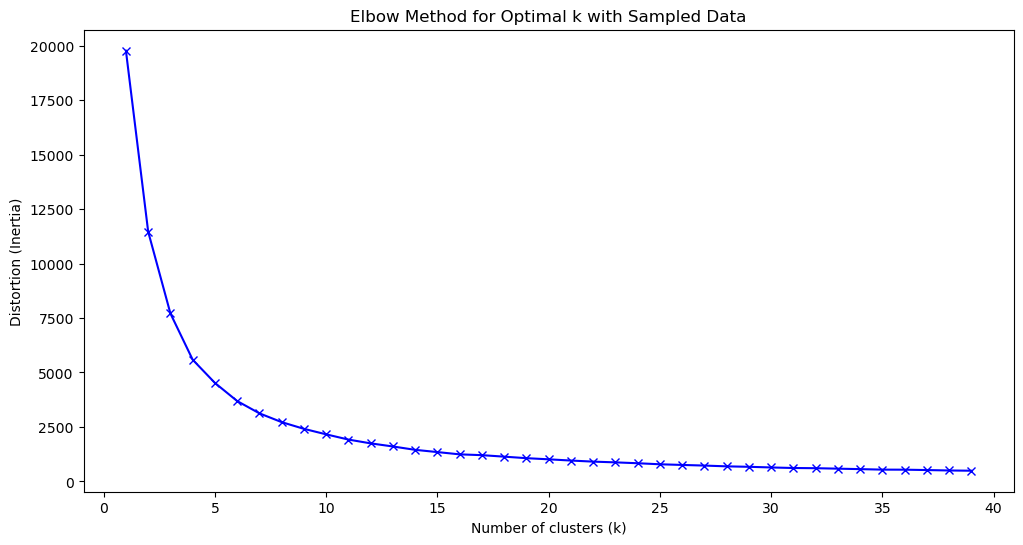

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Finding the optimal number of clusters with elbow method

#this method is time consuming so instead of using the entire dataset to find the optimal number of clusters,I am working with a random sample.

# sample_size = 10000 
# df = df.sample(n=sample_size, random_state=42)

# Extract coordinates from the sample
coordinates_sample = df[['start_station_latitude', 'start_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_sample)
# coordinates_sample = coordinates_standardized

#Elbow method
distortions = []
K = range(1, 40)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates_standardized)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k with Sampled Data')
plt.show()


## Cluster by starting station coordinates

In [10]:
from sklearn.cluster import KMeans
X = coordinates_sample.values   # We are clustering using sample due to computational efficiency. In the final version we will use the entire dataset
# X = df[['start_station_latitude', 'start_station_longitude']].values
# Cluster the data into 20 clusters
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=42).fit(X)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.labels_

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Plot the clusters

In [11]:
#First before plotting we have to deal with the outliers 
#The latitude of New York City is approximately between 40.4774 and 45.01585, and the longitude is approximately between -79.76259 and -71.18507.

lon_min = -79.76259
lat_min = 40.4774
lon_max = -71.18507
lat_max = 45.01585

# Store the stations that are within the boundaries
stations = df[
    (df['start_station_latitude'] > lat_min) &
    (df['start_station_latitude'] < lat_max) &
    (df['start_station_longitude'] > lon_min) &
    (df['start_station_longitude'] < lon_max)
]

print(stations)

          tripduration                 starttime                  stoptime  \
16303534           882  2018-11-25 18:21:38.7740  2018-11-25 18:36:21.4720   
10311866           669  2018-08-13 18:25:50.5440  2018-08-13 18:36:59.9680   
17229606           521  2018-12-18 20:12:15.0620  2018-12-18 20:20:57.0170   
4463430            270  2018-05-18 14:23:52.1050  2018-05-18 14:28:22.4910   
10376436           441  2018-08-14 19:00:15.8670  2018-08-14 19:07:37.0520   
...                ...                       ...                       ...   
14863760          1378  2018-10-24 11:29:21.2420  2018-10-24 11:52:19.9360   
15336225           484  2018-11-01 19:55:42.4370  2018-11-01 20:03:46.9640   
13020498           434  2018-09-24 19:20:19.0530  2018-09-24 19:27:33.9810   
13215998           641  2018-09-28 12:15:36.1200  2018-09-28 12:26:17.8850   
4635301            851  2018-05-22 07:04:24.4310  2018-05-22 07:18:35.9390   

          start_station_id  start_station_latitude  start_stati

In [12]:
# Plot the stations with an underlying map of New York City
subsampled_stations = stations.sample(n=1000, random_state=42)
title = 'Citi Bike Stations in New York City'
fig = px.scatter_mapbox(
    subsampled_stations,
    lat='start_station_latitude',
    lon='start_station_longitude',
    color='cluster',
    mapbox_style='carto-positron',
    zoom=9,
    width=1000,
    height=600
)
fig.update_layout(
    title=dict(
        text=title,
        x=0.5,  # Center the title horizontally
        xanchor='center',  # Anchor point for horizontal alignment
        font=dict(size=20)
    )
)
fig.show()

## Find the locations that are outliers (i.e, too far from the cluster centers) and remove them from the dataset

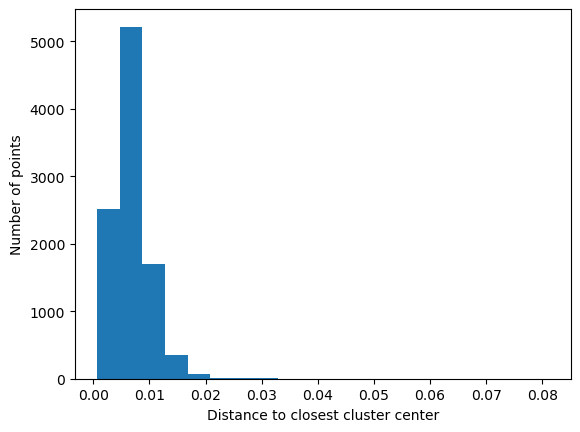

In [13]:
# Calculate the distance between each point and its cluster center
distance = kmeans.transform(X)

# Get the minimum distance for each point and its cluster index
min_distance = np.min(distance, axis=1)
min_distance_cluster = np.argmin(distance, axis=1)

# Plot a histogram of the minimum distance to a cluster center
plt.hist(min_distance, bins=20)
plt.xlabel('Distance to closest cluster center')
plt.ylabel('Number of points')
plt.show()

In [14]:
threshold = 0.015

# Get the indices of the points that are within the threshold distance of a cluster center
within_threshold = np.argwhere(min_distance < threshold).flatten()

# Remove the points that are outside the threshold distance of a cluster center
df_cleaned = df.iloc[within_threshold]
df_cleaned.info()

# Plot the stations with an underlying map of New York City
subsampled_stations = df_cleaned.sample(n=1000, random_state=42)
title = 'Citi Bike Stations in New York City'
fig = px.scatter_mapbox(
    subsampled_stations,
    lat='start_station_latitude',
    lon='start_station_longitude',
    color='cluster',
    mapbox_style='carto-positron',
    zoom=9,
    width=1000,
    height=600
)
fig.update_layout(
    title=dict(
        text=title,
        x=0.5,  # Center the title horizontally
        xanchor='center',  # Anchor point for horizontal alignment
        font=dict(size=20)
    )
)
fig.show()



<class 'pandas.core.frame.DataFrame'>
Index: 9711 entries, 16303534 to 4635301
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             9711 non-null   int64  
 1   starttime                9711 non-null   object 
 2   stoptime                 9711 non-null   object 
 3   start_station_id         9711 non-null   float64
 4   start_station_latitude   9711 non-null   float64
 5   start_station_longitude  9711 non-null   float64
 6   end_station_id           9711 non-null   float64
 7   end_station_latitude     9711 non-null   float64
 8   end_station_longitude    9711 non-null   float64
 9   bikeid                   9711 non-null   int64  
 10  usertype                 9711 non-null   object 
 11  birth_year               9711 non-null   int64  
 12  gender                   9711 non-null   int64  
 13  cluster                  9711 non-null   int32  
dtypes: float64(6), int3

## Finding the cluster with the most instances (the cluster with the biggest demand)

In [15]:
# Group the dataframe by 'cluster' and get the unique values of 'start_station_id' for each group
station_ids_by_cluster = df.groupby('cluster')['start_station_id'].unique()

# Looping through each group and for each station ID, filter the dataframe to get all the instances of that station in the cluster and sum them together
cluster_instances = {}
for cluster, station_ids in station_ids_by_cluster.items():
    total_instances = 0
    for station_id in station_ids:
        station_instances = df[(df['cluster'] == cluster) & (df['start_station_id'] == station_id)]
        total_instances += len(station_instances)
    cluster_instances[cluster] = total_instances

# Sort the dictionary by values in descending order
sorted_clusters = sorted(cluster_instances.items(), key=lambda x: x[1], reverse=True)

# Print the clusters in descending order by instances
# for cluster, instances in sorted_clusters:
#     print('Cluster', cluster, 'has', instances, 'instances')

print(f'Most important cluster: {sorted_clusters[0][0]}')
print(f'Number of instances: {sorted_clusters[0][1]}')

# Sum the number of instances for all clusters
print('------------------------------------------------------------------------------------------------------------------------')
print(f'Validating that the number of instances in all clusters (calculated) is equal to the total number of instances in the dataframe...')
total_instances = sum(cluster_instances.values())
print(f'Total number of instances: {total_instances}')
print(f'Percentage of instances in the most important cluster: {round(sorted_clusters[0][1] / total_instances * 100, 2)}%')
print(f'Number of all instances in the dataframe: {len(df)}')

Most important cluster: 16
Number of instances: 970
------------------------------------------------------------------------------------------------------------------------
Validating that the number of instances in all clusters (calculated) is equal to the total number of instances in the dataframe...
Total number of instances: 9882
Percentage of instances in the most important cluster: 9.82%
Number of all instances in the dataframe: 9883


In [16]:
#Trasform startime and stoptimeinto datetime data
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9883 entries, 16303534 to 4635301
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             9883 non-null   int64         
 1   starttime                9883 non-null   datetime64[ns]
 2   stoptime                 9883 non-null   datetime64[ns]
 3   start_station_id         9882 non-null   float64       
 4   start_station_latitude   9883 non-null   float64       
 5   start_station_longitude  9883 non-null   float64       
 6   end_station_id           9882 non-null   float64       
 7   end_station_latitude     9883 non-null   float64       
 8   end_station_longitude    9883 non-null   float64       
 9   bikeid                   9883 non-null   int64         
 10  usertype                 9883 non-null   object        
 11  birth_year               9883 non-null   int64         
 12  gender                   9883

## Create time series of the duration of the trip

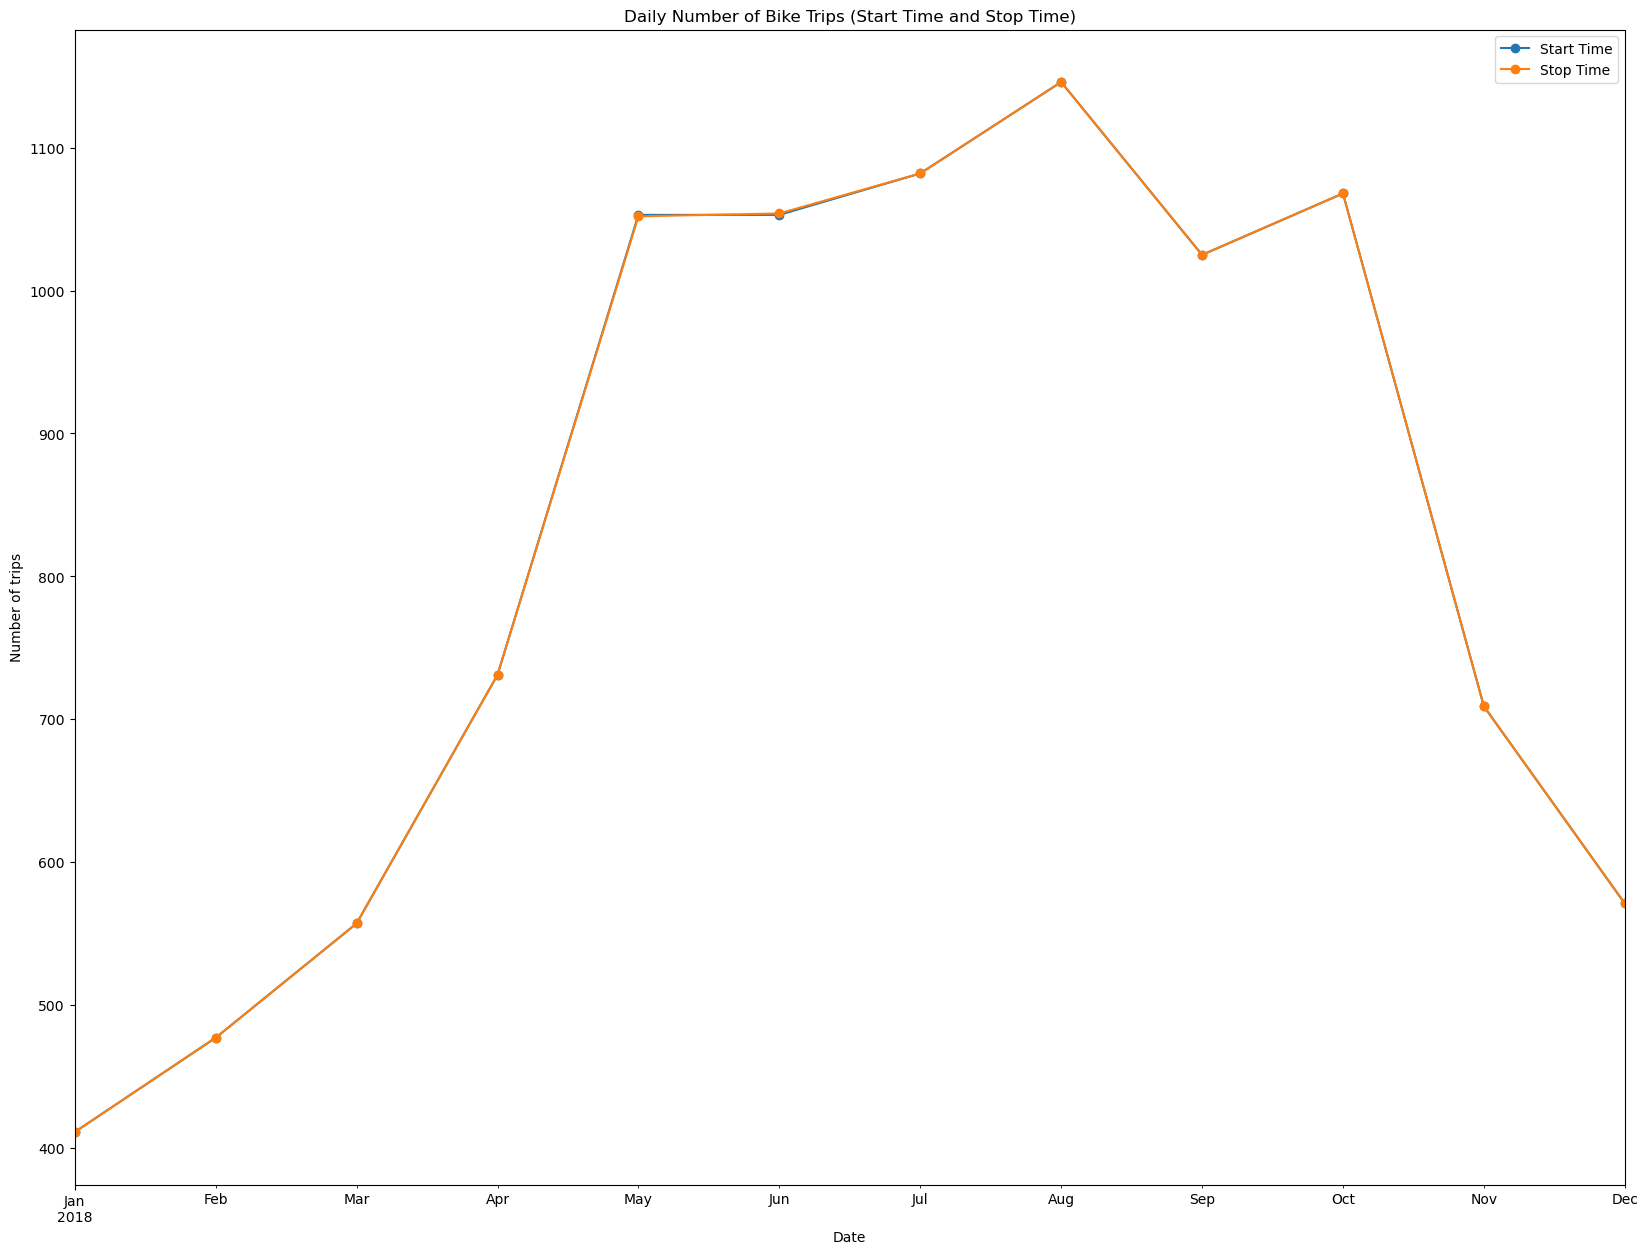

In [17]:
# Convert start time and stoptime to datetime
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Time series analysis
# Extract the start time and trip duration columns
start_time_series = df[['starttime', 'tripduration']]
stop_time_series = df[['stoptime', 'tripduration']]

# Set the start time as the index for start_time_series
start_time_series.set_index('starttime', inplace=True)

# Set the stoptime as the index for stop_time_series
stop_time_series.set_index('stoptime', inplace=True)

# Resample the data by day and calculate the total number of trips per day for start and stop times
daily_trips_start = start_time_series.resample('M').size()
daily_trips_stop = stop_time_series.resample('M').size()

# Plot the time series for both start and stop times
plt.figure(figsize=(20, 15))
daily_trips_start.plot(label='Start Time', marker='o', linestyle='-')
daily_trips_stop.plot(label='Stop Time', marker='o', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.title('Daily Number of Bike Trips (Start Time and Stop Time)')
plt.legend()
plt.show()

## Plot the bike trip duration

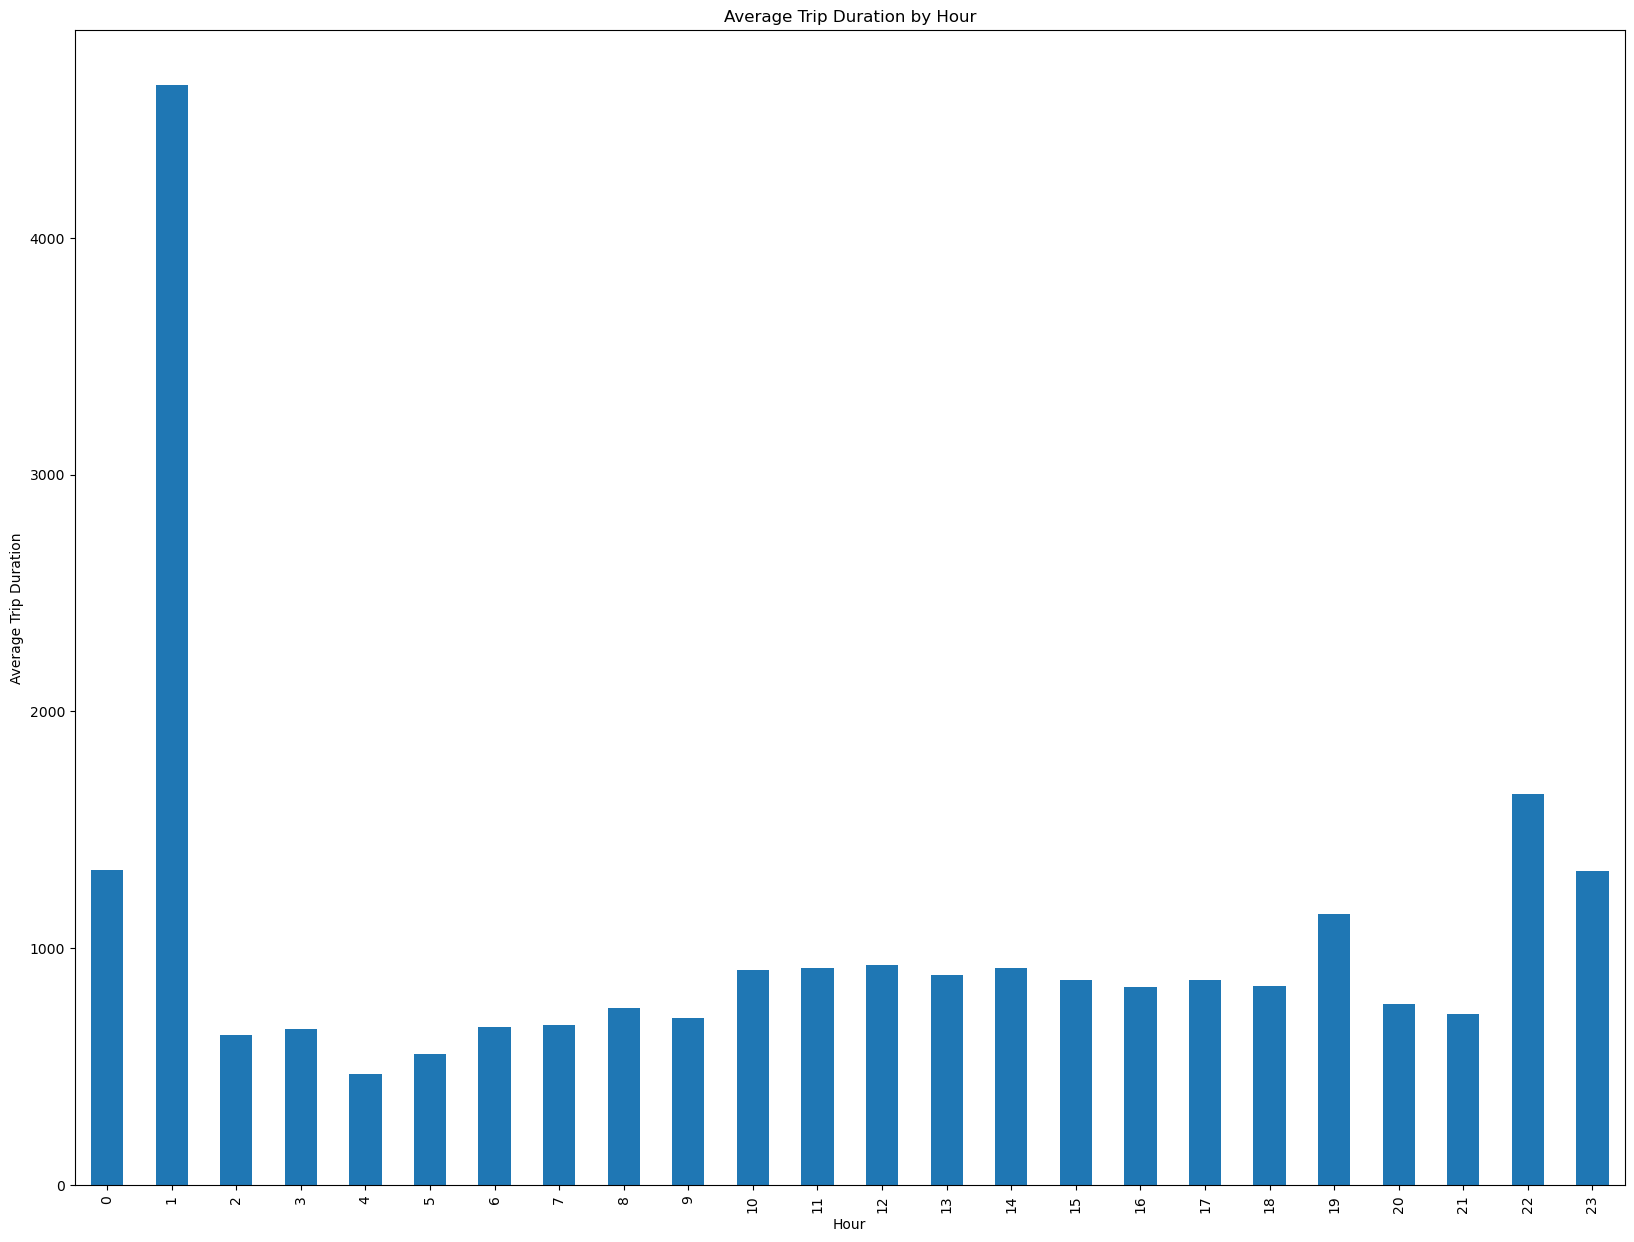

In [18]:
# Group trip duration by hour and plot the average trip duration per hour
plt.figure(figsize=(20, 15))
df.groupby(df['starttime'].dt.hour)['tripduration'].mean().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Average Trip Duration')
plt.title('Average Trip Duration by Hour')
plt.show()



In [19]:
kmeans_full = KMeans(n_clusters=20, init='k-means++', random_state=42)
kmeans_full.fit(df[['start_station_latitude', 'start_station_longitude']])

# Now predict using the full DataFrame with column names
df['cluster'] = kmeans_full.predict(df[['start_station_latitude', 'start_station_longitude']])

# Use .copy() to ensure you have a copy of the DataFrame if you're slicing before #I used it cause it wasnt working before
df = df.copy()

df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Aggregate data by hour for the entire dataset
df['hour'] = df['starttime'].dt.hour
df['date'] = df['starttime'].dt.date


/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [20]:
# # Create a groupby object for hourly aggregation
# grouped = df.groupby(['date', 'hour', 'cluster'])

# # Aggregate data by count (number of pickups and drop-offs) 
# hourly_data = grouped.agg({
#     'start_station_id': 'count',  # Number of pickups
#     'end_station_id': 'count',    # Number of drop-offs
# }).rename(columns={
#     'start_station_id': 'hourly_pickups',
#     'end_station_id': 'hourly_dropoffs'
# })

# # Reset index to turn groupby indices into columns
# hourly_data.reset_index(inplace=True)

# train_data = hourly_data[hourly_data['date'] <= pd.to_datetime('2018-10-31')]
# test_data = hourly_data[hourly_data['date'] > pd.to_datetime('2018-10-31')]

# # Prepare the feature matrix 'X' by dropping the target variable and the 'date' column
# X_train = train_data.drop(['hourly_pickups', 'hourly_dropoffs', 'date'], axis=1)
# X_test = test_data.drop(['hourly_pickups', 'hourly_dropoffs', 'date'], axis=1)

# # The 'date' column should be converted to a numeric format, such as Unix timestamp, or extracted as year, month, day, etc.
# train_data['timestamp'] = train_data['date'].apply(lambda x: x.timestamp())
# test_data['timestamp'] = test_data['date'].apply(lambda x: x.timestamp())

# # Include the Unix timestamp as a feature
# X_train['timestamp'] = train_data['timestamp']
# X_test['timestamp'] = test_data['timestamp']

# # Convert 'hour' and 'day_of_week' to categorical features
# X_train = pd.get_dummies(X_train, columns=['hour', 'cluster'])
# X_test = pd.get_dummies(X_test, columns=['hour', 'cluster'])

# # Ensure that 'day_of_week' is also included as a feature after encoding
# X_train['day_of_week'] = train_data['date'].dt.dayof_week
# X_test['day_of_week'] = test_data['date'].dt.day_of_week

# # Prepare the target variable 'y'
# y_train = train_data['hourly_pickups']
# y_test = test_data['hourly_pickups']

In [21]:
# from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor()

# rf.fit(X_train, y_train)

# predictions = rf.predict(X_test)

# mse = mean_squared_error(y_test, predictions)
# rmse = mse ** 0.5
# print(f'RMSE: {rmse}')


In [22]:
# # Plotting actual vs predicted values
# plt.figure(figsize=(15, 5))
# plt.plot(y_test.index, y_test, label='Actual')
# plt.plot(y_test.index, predictions, label='Predicted')
# plt.title('Actual vs Predicted Trips')
# plt.xlabel('Time')
# plt.ylabel('Number of Trips')
# plt.legend()
# plt.show()


### To Do:
> Further data cleaning (tweaking of DBSCAN -current results are incorrect- and possibly removing values after clustering)

> Implementation of Linear Regression as baseline model (current one is incorrect)

> Decision on the ML model to use..

### Research questions:
> 1)predict which bikes are likely to require maintenance or which stations will need servicing based on usage patterns. Modeling: Time series forecasting, survival analysis.

>2)User behaviour analysis:How do subscriber patterns differ from casual customer patterns in terms of trip duration, distance, and frequency?For modeling we are going to use statistical tests for differences, classification algorithms for user type prediction.

>3)How does the pricing structure impact user behavior, and can dynamic pricing optimize usage and revenue? Analysis:Correlation between pricing changes and usage patterns. Modeling:Regression models to predict usage based on 


In [23]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# # Prepare the feature matrix 'X' by dropping the target variable and the 'date' column
# X_train = train_data.drop(['cluster'], axis=1)
# X_test = test_data.drop(['cluster'], axis=1)

X_train = train_data.drop(['cluster', 'starttime', 'stoptime'], axis=1)
X_test = test_data.drop(['cluster', 'starttime', 'stoptime'], axis=1)

# The 'date' column should be converted to a numeric format, such as Unix timestamp, or extracted as year, month, day, etc.
train_data['starttime'] = pd.to_datetime(train_data['starttime'])
test_data['starttime'] = pd.to_datetime(test_data['starttime'])

y_train = train_data['starttime'].dt.hour
y_test = test_data['starttime'].dt.hour

X_train.info()





<class 'pandas.core.frame.DataFrame'>
Index: 7906 entries, 15072094 to 5931799
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             7906 non-null   int64  
 1   start_station_id         7905 non-null   float64
 2   start_station_latitude   7906 non-null   float64
 3   start_station_longitude  7906 non-null   float64
 4   end_station_id           7905 non-null   float64
 5   end_station_latitude     7906 non-null   float64
 6   end_station_longitude    7906 non-null   float64
 7   bikeid                   7906 non-null   int64  
 8   usertype                 7906 non-null   object 
 9   birth_year               7906 non-null   int64  
 10  gender                   7906 non-null   int64  
 11  hour                     7906 non-null   int32  
 12  date                     7906 non-null   object 
dtypes: float64(6), int32(1), int64(4), object(2)
memory usage: 833.8+ KB


In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

# Plotting actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Trips')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()


ValueError: could not convert string to float: 'Subscriber'

# Cluster with the highest demand is 16. We analyze this

In [ ]:
df_important_cluster = df[df['cluster'] == sorted_clusters[0][0]]

# Prepare the feature matrix 'X' by dropping the target variable and the 'date' column
X = df_important_cluster.drop(['cluster', 'starttime', 'stoptime'], axis=1)

# The 'date' column should be converted to a numeric format, such as Unix timestamp, or extracted as year, month, day, etc.
df_important_cluster['starttime'] = pd.to_datetime(df_important_cluster['starttime'])

In [ ]:
# Ensure 'starttime' is in datetime format
df_important_cluster['starttime'] = pd.to_datetime(df_important_cluster['starttime'])

# Filter out non-null values in 'starttime' column
df_important_cluster = df_important_cluster[df_important_cluster['starttime'].dt.hour.notnull()]

# Extract the hour from 'starttime'
y = df_important_cluster['starttime'].dt.hour

# Continue with the rest of the code
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create an SVR model
svr = make_pipeline(StandardScaler(), SVR())

# Fit the SVR model
svr.fit(X, y_encoded)

# Predict using the SVR model
predictions = svr.predict(X)

# Calculate RMSE
mse = mean_squared_error(y_encoded, predictions)
rmse = mse ** 0.5
print(f'RMSE (SVM): {rmse}')



# Trying with linear regression

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
df_important_cluster = df[df['cluster'] == sorted_clusters[0][0]]
# Import necessary libraries

# Prepare the feature matrix 'X' by dropping the target variable and the 'date' column
X = df_important_cluster.drop(['cluster', 'starttime', 'stoptime'], axis=1)

# The 'date' column should be converted to a numeric format, such as Unix timestamp, or extracted as year, month, day, etc.
df_important_cluster['starttime'] = pd.to_datetime(df_important_cluster['starttime'])

# Extract the hour from 'starttime'
df_important_cluster['hour'] = df_important_cluster['starttime'].dt.hour

# Prepare the target variable 'y'
y = df_important_cluster['hour']

# Create a Linear Regression model
lr = LinearRegression()

# Fit the Linear Regression model
lr.fit(X, y)

# Predict using the Linear Regression model
predictions = lr.predict(X)

# Calculate RMSE
mse = mean_squared_error(y, predictions)
rmse = mse ** 0.5
print(f'RMSE (Linear Regression): {rmse}')


/tmp/ipykernel_8038/874924935.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_8038/874924935.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: could not convert string to float: 'Subscriber'